In [1]:
import os

In [2]:
%cd ../

/home/hawobade/MLOps/Anomaly-Detection-System-in-Network-Traffic


In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    data_path: Path
    preprocessed_data: Path

In [4]:
from anomalyDetection import logger
from anomalyDetection.constants import *
from anomalyDetection.utils.common import read_yaml, create_directories


In [5]:
class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH, schema_filepath=SCHEMA_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation

        create_directories([config.root_dir])

        data_transformation_config = DataTransformationConfig(
            root_dir=config.root_dir,
            data_path=config.data_path,
            preprocessed_data=config.preprocessed_data,
        )
        return data_transformation_config

In [6]:
import os
from anomalyDetection import logger
from sklearn.model_selection import train_test_split
import pandas as pd
from anomalyDetection import logging
import numpy as np

In [7]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig) -> None:
        self.config = config

    def preprocess_data(self):
        """
        Preprocess steps;
            - drop missing values (nan, -inf, inf)
            - encode categorical variables
        """
        # missing values
        df = pd.read_csv(self.config.data_path)
        logger.info("Shape before removing inf, -inf values and nan values: {str(df.shape)}")
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        df.drop_duplicates(keep="first", inplace=True)
        logger.info(f"Shape after removing duplicates, inf, -inf values and nan values: {str(df.shape)}")
        # encode categorical variables
        df.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
        df.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
        df.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)
        df.Label.replace(["DoS", "PortScan", "DDoS", "Brute Force", "Web Attack", "Bot", "Infiltration", "Heartbleed"], "Attack", inplace=True)
        df.Label.replace("BENIGN", "Normal", inplace=True)
        logger.info(f"The target labels are:  {df.Label.unique().tolist()}")
        df.Label.replace({"Normal": 1, "Attack": -1}, inplace=True)
        df.to_csv(self.config.preprocessed_data, index=False)

    def split_data(self):
        data = pd.read_csv(self.config.preprocessed_data)

        logger.info("Splitting data...")
        train_data, test_data = train_test_split(data, random_state=42, shuffle=True)

        train_data.to_csv(os.path.join(self.config.root_dir, 'train.csv'), index=False)
        test_data.to_csv(os.path.join(self.config.root_dir, 'test.csv'), index=False)

        logger.info(f"Train shape: {train_data.shape}")
        logger.info(f"test shape: {test_data.shape}")

In [8]:
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    data_transformation = DataTransformation(data_transformation_config)
    data_transformation.preprocess_data()
    data_transformation.split_data()
except Exception as e:
    raise e

[2023-10-21 02:09:55,220: INFO: common: yaml file: config/config.yaml loaded successfully]
[2023-10-21 02:09:55,229: INFO: common: yaml file: params.yaml loaded successfully]
[2023-10-21 02:09:55,242: INFO: common: yaml file: schema.yaml loaded successfully]
[2023-10-21 02:09:55,245: INFO: common: created directory at: artifacts]
[2023-10-21 02:09:55,247: INFO: common: created directory at: artifacts/data_transformation]


[2023-10-21 02:10:33,439: INFO: 2303816588: Shape before removing inf, -inf values and nan values: {str(df.shape)}]
[2023-10-21 02:10:58,969: INFO: 2303816588: Shape after removing duplicates, inf, -inf values and nan values: (2520798, 79)]
[2023-10-21 02:11:05,297: INFO: 2303816588: The target labels are:  ['Normal', 'Attack']]
[2023-10-21 02:13:11,733: INFO: 2303816588: Splitting data...]
[2023-10-21 02:14:59,394: INFO: 2303816588: Train shape: (1890598, 79)]
[2023-10-21 02:14:59,396: INFO: 2303816588: test shape: (630200, 79)]


In [14]:
data_dir = Path('artifacts/data_ingestion/cicdataset')
csv_files = list(data_dir.glob(r'*/*/*.csv'))
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)    

In [15]:
print('Shape before removing inf, -inf values and nan values: ', df.shape)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print('Shape after removing inf, -inf values and nan values: ', df.shape)
df.columns = df.columns.str.strip()

Shape before removing inf, -inf values and nan values:  (2830743, 79)
Shape after removing inf, -inf values and nan values:  (2827876, 79)


In [16]:
df_experiment = df.copy()
df_experiment.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
df_experiment.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
df_experiment.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)
df_experiment.Label.value_counts()

Label
BENIGN          2271320
DoS              251712
PortScan         158804
DDoS             128025
Brute Force       13832
Web Attack         2180
Bot                1956
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

In [19]:
df_experiment = df_experiment[~df_experiment['Label'].isin(['Infiltration', 'Heartbleed'])]
df_experiment['Label'].value_counts()

Label
BENIGN         2271320
DoS             251712
PortScan        158804
DDoS            128025
Brute Force      13832
Web Attack        2180
Bot               1956
Name: count, dtype: int64

<Axes: xlabel='Label'>

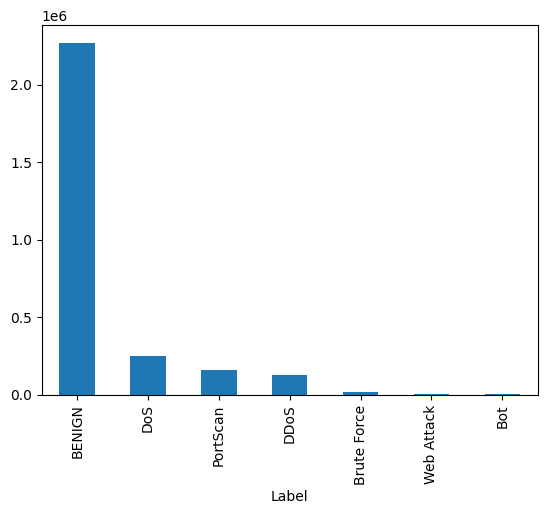

In [20]:
df_experiment['Label'].value_counts().plot(kind='bar')